# Threshold sensitivity

Explores the sensitivity of the simulation to various choices of threshold, presented in the supplement

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# unchanged from example

import networkx as nx
import numpy as np
import itertools
import pandas as pd
import copy
from sklearn.decomposition import PCA


def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            return nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2  # current holders are also susceptible
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return False  # no path exists between the nodes


def adopt(g, agent, belief):
    """Assess whether an agent will adopt a given belief"""
    suscep = susceptible(g, agent, belief)
    exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
    return suscep and exposed  # both susceptibility and exposure required to adopt



def run(n_agents=60, deg=3, n_concepts=25, n_beliefs=25, t_match_susceptibility=0, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------
    # create a random connected social network g0
    connected = False
    while not connected:
        g0 = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
        connected = nx.is_connected(g0)

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Interdependent simulation
    # -------------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Independent simulation
    # ----------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions

    # calculate the population likelihood of being susceptible to a given (non-held) belief
    p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
         (1 - res1.loc[0, '% adopted']))

    # choose a set of beliefs for each agent to be susceptible to
    new_sus = {}
    for agent in g2:
        gc = nx.complete_graph(n_concepts)  # potentially susceptible to any belief
        gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
        # from remainder, randomly select a subset of beliefs to be susceptible to
        edges = list(itertools.compress(
            list(gc.edges()),  # selection candidates
            np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
        ))
        edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
        new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

    nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame


In [3]:
def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    #m0, initial_susceptible, initial_adopted = measure(g, beliefs)  # measure initial conditions
    #m = [m0]  # array to collect measurements at each time step
    m=[]
    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network
    
    m.append(measure(g, beliefs, 0, 0)[0])  # measure only final state

    return pd.DataFrame(m)  # format as pandas DataFrame

In [4]:
# changes made here remove some of the measurements that are not needed for the sensitivity analysis
# and also vary the thresholds used over the full range, returning the result.

def measure(g, beliefs, initial_susceptible=None, initial_adopted=None):
    """Take measurements of the state of the system (for creating figures)"""
    res = {}  # dictionary to collect measurements

    # Fig 2A: Susceptible and adopting populations
    # --------------------------------------------
    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

    # Fig 2B:correlation between predicted new adoption and actual new adoption
    # -------------------------------------------------------------------------
#     if initial_adopted is not None and initial_susceptible is not None:  # t>0
#         res['initial prediction correlation'] = np.corrcoef(
#             adopt.sum(axis=0) - initial_adopted,
#             initial_susceptible - initial_adopted
#         )[1, 0]  # select an off-diagonal term
#     else:  # first time => establish baseline
#         initial_adopted = adopt.sum(axis=0)
#         initial_susceptible = suscep.sum(axis=0)
#         res['initial prediction correlation'] = np.nan  # measure has no meaning at t0

    # Fig 2C: correlation between a belief and it's most popular neighbor
    # -------------------------------------------------------------------
    adopt_counts = pd.DataFrame()
    adopt_counts['self'] = adopt.sum(axis=0)
    adopt_counts['leading neighbor'] = 0
    for c1 in adopt.columns:
        # search for the leading neighbor's popularity
        leading_value = 0
        for c2 in adopt.columns:
            if len((set(c1) | set(c2))) == 3:  # three nodes total => c1 and c2 are neighbors
                leading_value = max(leading_value, adopt_counts.loc[[c2], 'self'].values[0])
        adopt_counts.at[[c1], 'leading neighbor'] = leading_value
    #res['leading neighbor correlation'] = adopt_counts.corr().loc['self', 'leading neighbor']

    # Fig 2D: clustering coefficient of 10% most popular beliefs
    # ----------------------------------------------------------
    # shuffle within sorted value so that when 10% falls within a level of popularity
    # we don't add spurious clustering by selecting sequential beliefs
    adopt_counts['shuffle'] = np.random.rand(len(adopt_counts))
    adopt_counts.sort_values(by=['self', 'shuffle'], inplace=True, ascending=False)
    cluster_list = []
    for percent in np.arange(0.01,1,.01):
        leaders = adopt_counts.iloc[:int(len(adopt_counts) * percent)]  # take leading percent of beliefs
        popular_graph = nx.from_edgelist(list(leaders.index))  # construct semantic network from leading beliefs
        cluster_list.append(nx.average_clustering(popular_graph))
    res['popular belief clustering'] = np.array(cluster_list)

    # Fig 3A: similarity btw 5% and 95% most similar pairs
    # ----------------------------------------------------
    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    
    res['percentiles similarity'] = np.percentile(corrs, np.arange(1,100,1))

    # Fig 3B: PC1 percent variance
    # ----------------------------
    #pca = PCA(n_components=1)
    #pca.fit(adopt)
    #res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res, initial_susceptible, initial_adopted

In [6]:
res = []

In [129]:
n_sims = 1000
#res = []
for i in range(n_sims):
    try:
        res.append(run())
        print('.')
    except KeyboardInterrupt:
        raise
    except:
        print('!')

    
df = pd.concat(res)
df

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


KeyboardInterrupt: 

In [138]:
df = pd.concat(res)
df.to_pickle('threshold_sensitivities.pickle')

In [131]:
plt.rcParams.update({
    "figure.dpi": 100,
    "figure.figsize": (4, 3),
    "figure.facecolor": "white", #"lightyellow",
    
    "savefig.dpi": 150,
    
    "font.family": "san-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 8,
    
    "lines.linewidth": 2,
    "lines.marker": "",
    "lines.markersize": 8,
    
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": "grey",
    "axes.labelsize": 8,
    "axes.labelcolor": "grey",
    "axes.facecolor": "#00000000",
    
    "xtick.color": "grey",
    "xtick.labelsize": 8,
    "xtick.major.size": 2,
    
    "ytick.major.size": 0,
    "ytick.color": "grey",
    "ytick.labelsize": 8,
    
    "text.color": "grey",
    "text.usetex": False
})


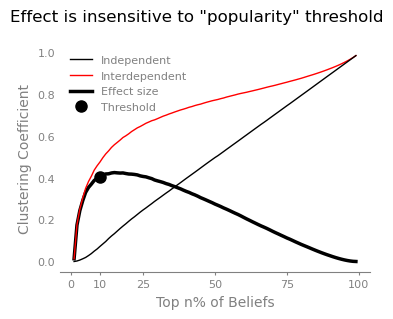

In [141]:
from scipy import signal

collector = []
for i, row in df['popular belief clustering (inter)'].items():
    collector.append(row)
    
inter_df = pd.DataFrame(collector, columns=range(1,100,1))
#inter_clustering = signal.savgol_filter(inter_df.mean(), 15, 2)
inter_clustering = inter_df.mean()

collector = []
for i, row in df['popular belief clustering (indep)'].items():
    collector.append(row)
    
indep_df = pd.DataFrame(collector, columns=range(1,100,1))
#indep_clustering = signal.savgol_filter(indep_df.mean(), 15, 2)
indep_clustering = indep_df.mean()

#effect = signal.savgol_filter((inter_df - indep_df).mean(), 15, 2)
effect = (inter_df - indep_df).mean()


plt.plot(indep_clustering, 'k', label="Independent", alpha=1, linewidth=1, zorder=10)
plt.plot(inter_clustering, 'r', label="Interdependent", alpha=1, linewidth=1, zorder=9)
plt.plot(effect, 'k', label="Effect size", alpha=1, linewidth=2.5, zorder=8)
plt.plot(10, effect.loc[10], 'ko', label='Threshold')


plt.xlabel("Top n% of Beliefs", fontsize=10)
plt.ylabel("Clustering Coefficient", fontsize=10)
plt.xticks([0, 10, 25, 50, 75, 100])
plt.legend(frameon=False, loc='upper left')
plt.suptitle('Effect is insensitive to "popularity" threshold', 
             x=0, y=1, ha='left', va='top', fontsize=12, color='k');
plt.savefig("insensitive_to_popularity_threshold.png", dpi=200)

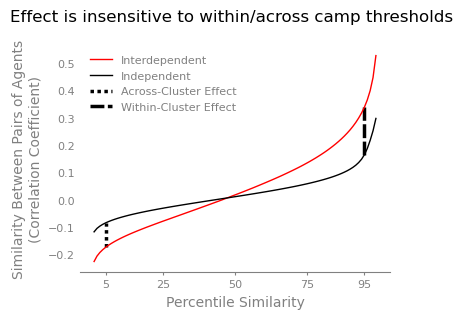

In [142]:
collector = []
for i, row in df['percentiles similarity (inter)'].items():
    collector.append(row)
    
inter_df = pd.DataFrame(collector, columns=range(1,100,1))
#inter_df = inter_df[inter_df.columns[::3]]
inter_similarity = inter_df.mean()

collector = []
for i, row in df['percentiles similarity (indep)'].items():
    collector.append(row)
    
indep_df = pd.DataFrame(collector, columns=range(1,100,1))
#indep_df = indep_df[indep_df.columns[::3]]
indep_similarity = indep_df.mean()

effect = (inter_df - indep_df).mean()
#plt.plot(effect, 'k', label="Effect size", alpha=1, linewidth=2.5)

plt.plot(inter_similarity, 'r', label="Interdependent", alpha=1, linewidth=1)
plt.plot(indep_similarity, 'k', label="Independent", alpha=1, linewidth=1)

plt.vlines(5, inter_similarity.loc[5], indep_similarity.loc[5], 'k', linestyles=(0,(1,1)), linewidth=2.5, label="Across-Cluster Effect")
plt.vlines(95, indep_similarity.loc[95], inter_similarity.loc[95], 'k', linestyles=(0,(4,1)), linewidth=2.5, label="Within-Cluster Effect")

plt.xlabel("Percentile Similarity", fontsize=10)
plt.ylabel("Similarity Between Pairs of Agents\n(Correlation Coefficient)", fontsize=10)
plt.xticks([5, 25, 50, 75, 95])
plt.legend(frameon=False)
plt.suptitle('Effect is insensitive to within/across camp thresholds', 
             x=-.05, y=1, ha='left', va='top', fontsize=12, color='k');
plt.savefig("insensitive_to_camp_thresholds.png", dpi=200, bbox_inches='tight')
